Run ID 251001TG_CalTemp
EXP ID EXP_H_250414_CV1_A2
running getData
C:\Users\jonny\Lehigh University Dropbox\ENG-MATSGroup\MATS\cRIO\RunConfig\EXPs\\EXP_H_250414_CV1_A2.csv
TC Positions
     0
0  246
1  195
2  195
3  157
4  157
5  157
6  120
7  120
8   69
TC_positions:
8     69.0
6    120.0
7    120.0
3    157.0
4    157.0
5    157.0
1    195.0
2    195.0
0    246.0
Name: X Position, dtype: float64
TC_df:
  Device Type NI LV Channel    Shorthand Tag  X Position
8          TC      CV1-TC38    T1-TC-69(180)        69.0
6          TC      CV1-TC48     T1-TC-120(0)       120.0
7          TC      CV1-TC36   T1-TC-120(180)       120.0
3          TC      CV1-TC47     T1-TC-157(0)       157.0
4          TC      CV1-TC34  T1-TC-157(180)*       157.0
5          TC      CV1-TC34  T1-TC-157(180)*       157.0
1          TC      CV1-TC46     T1-TC-195(0)       195.0
2          TC      CV1-TC32   T1-TC-195(180)       195.0
0          TC      CV1-TC30   T1-TC-246(180)       246.0
Pressure
140801
12    

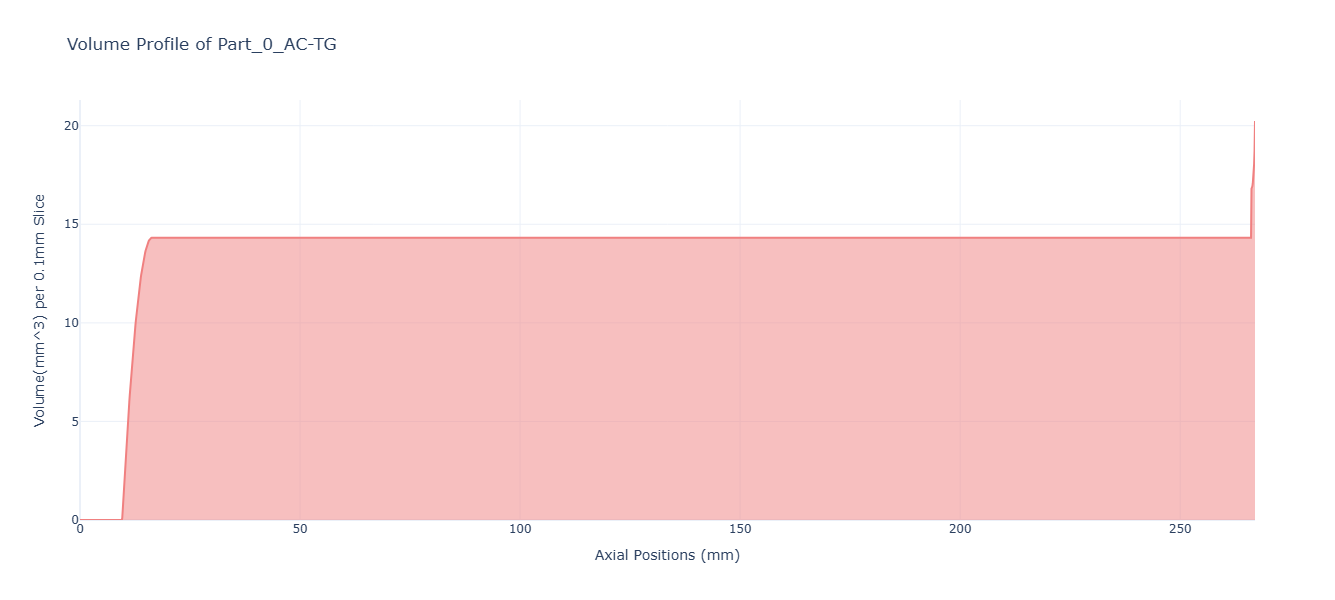

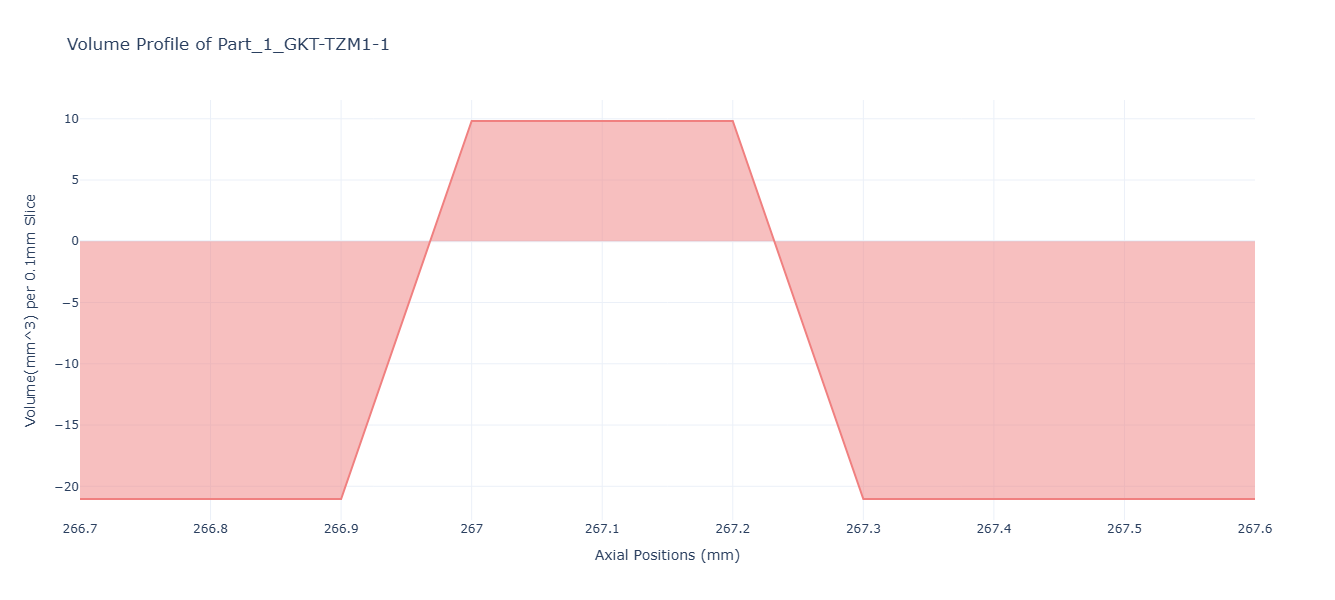

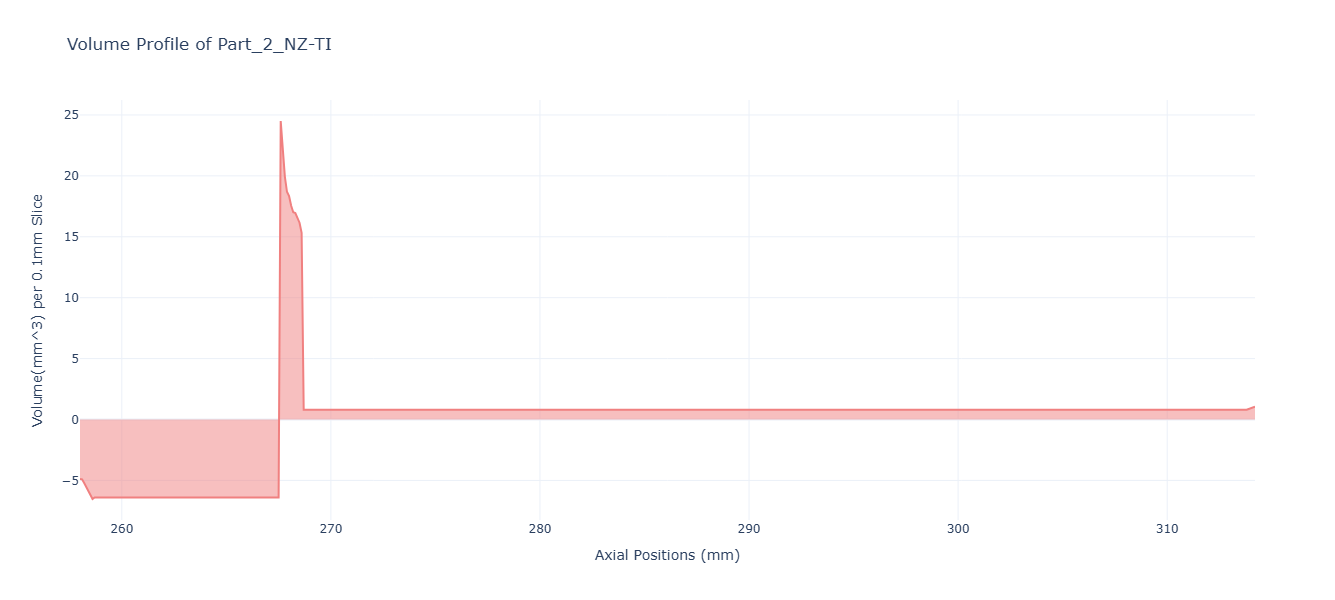

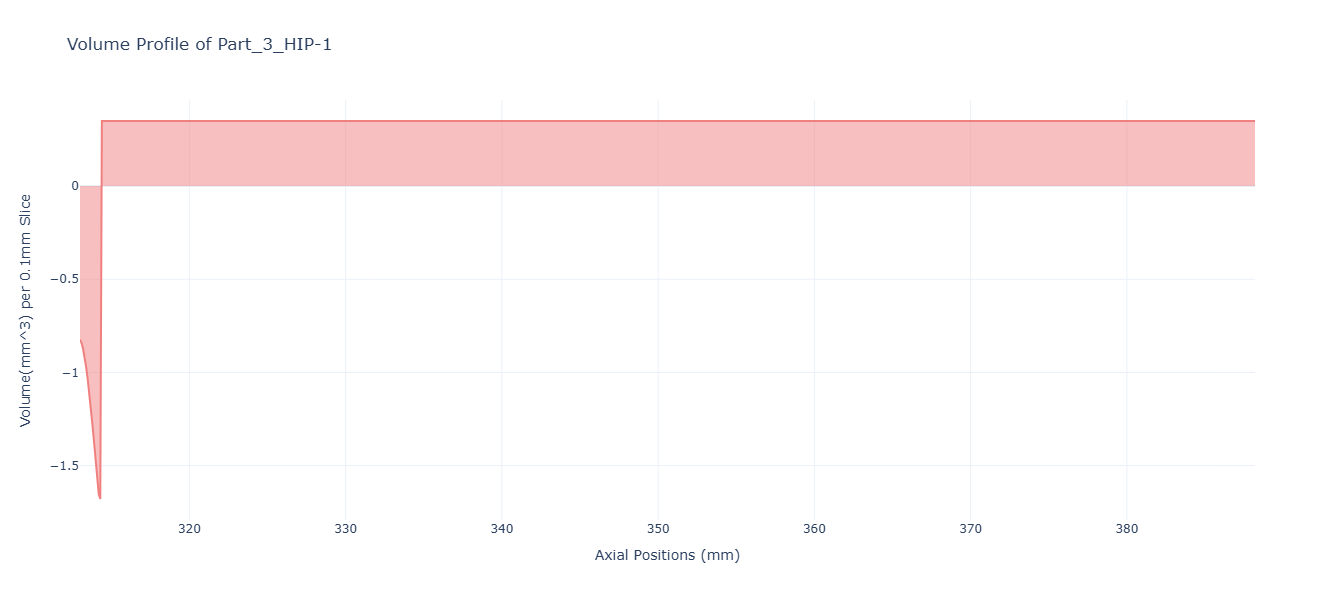

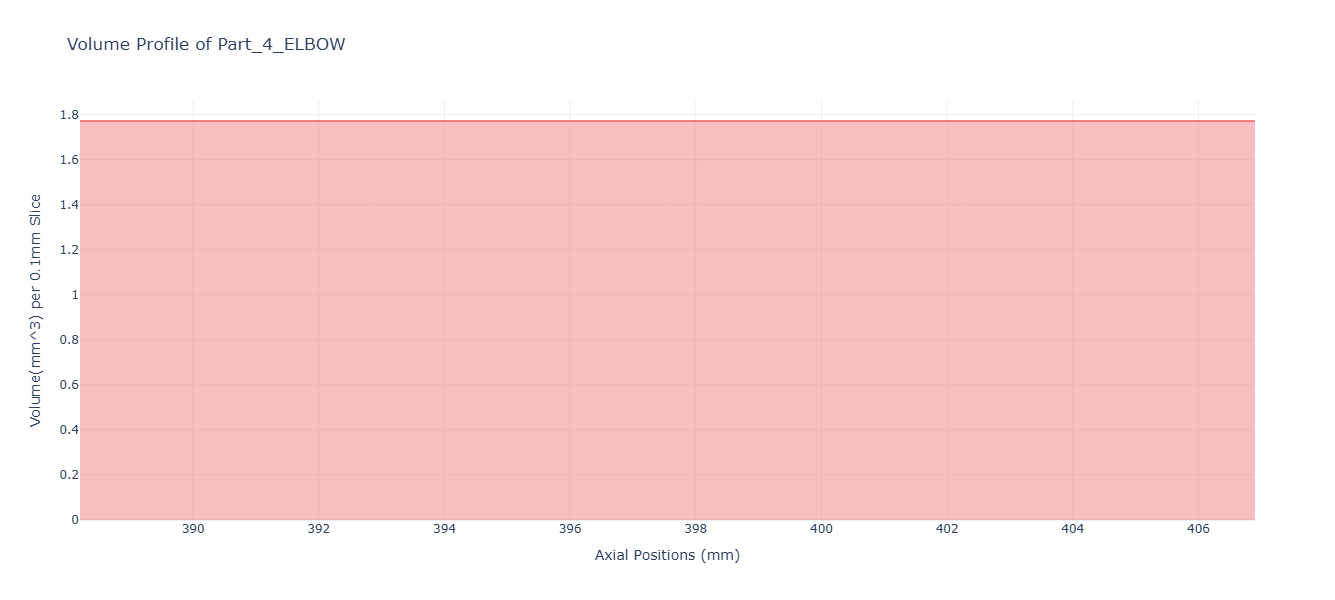

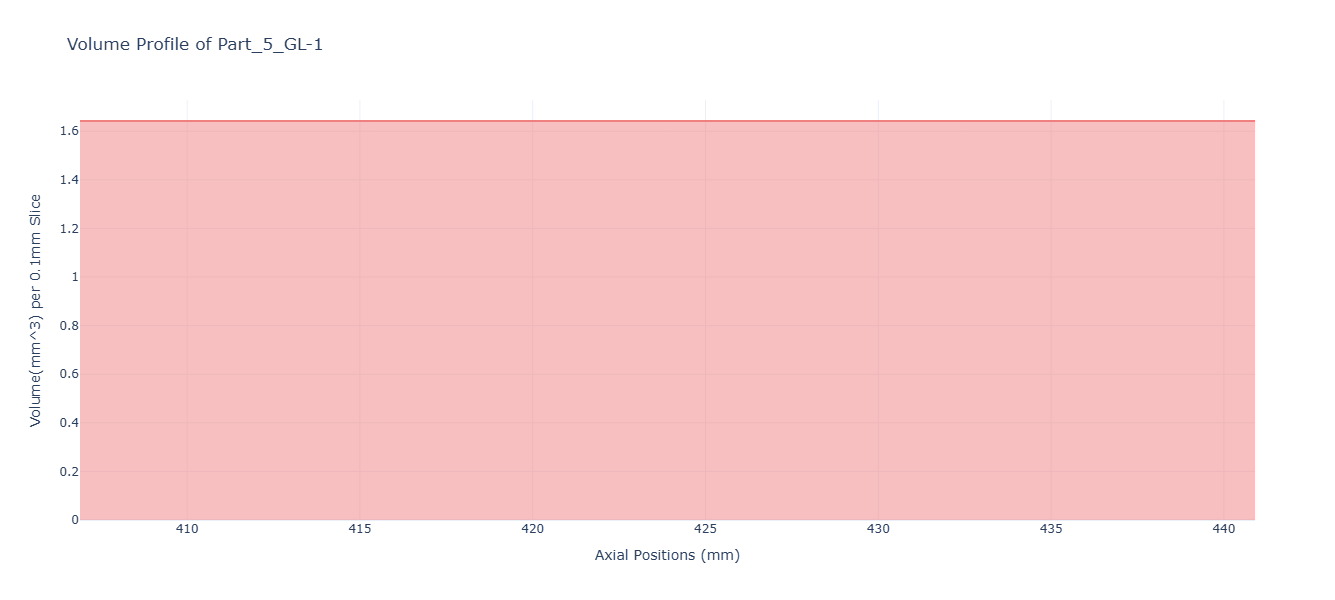

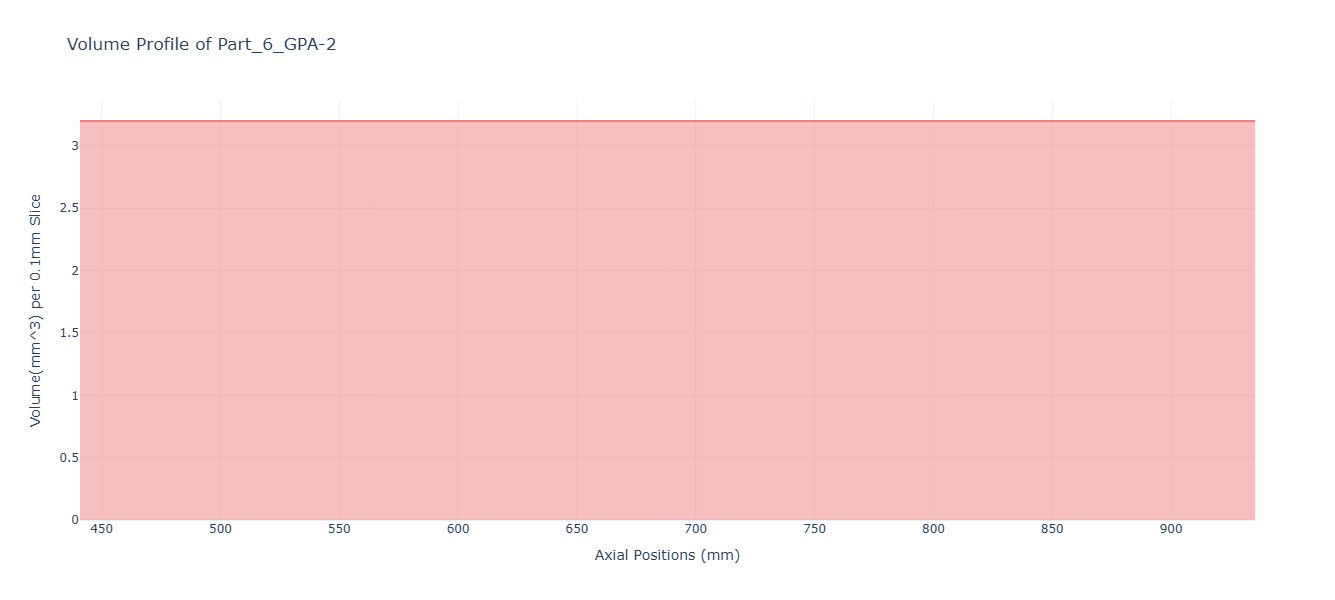

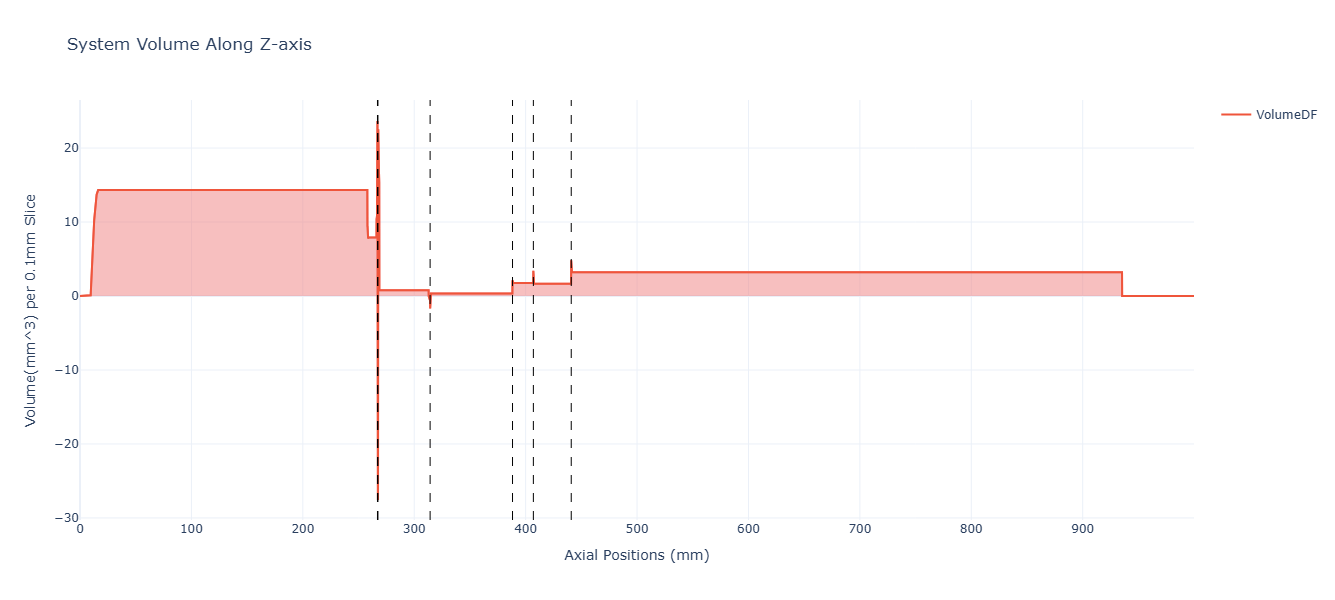



Total System Volume from VolumeDF (mL): 53.35772023623807
Total System Volume from CoarseVol (mL): 53.357720236238066


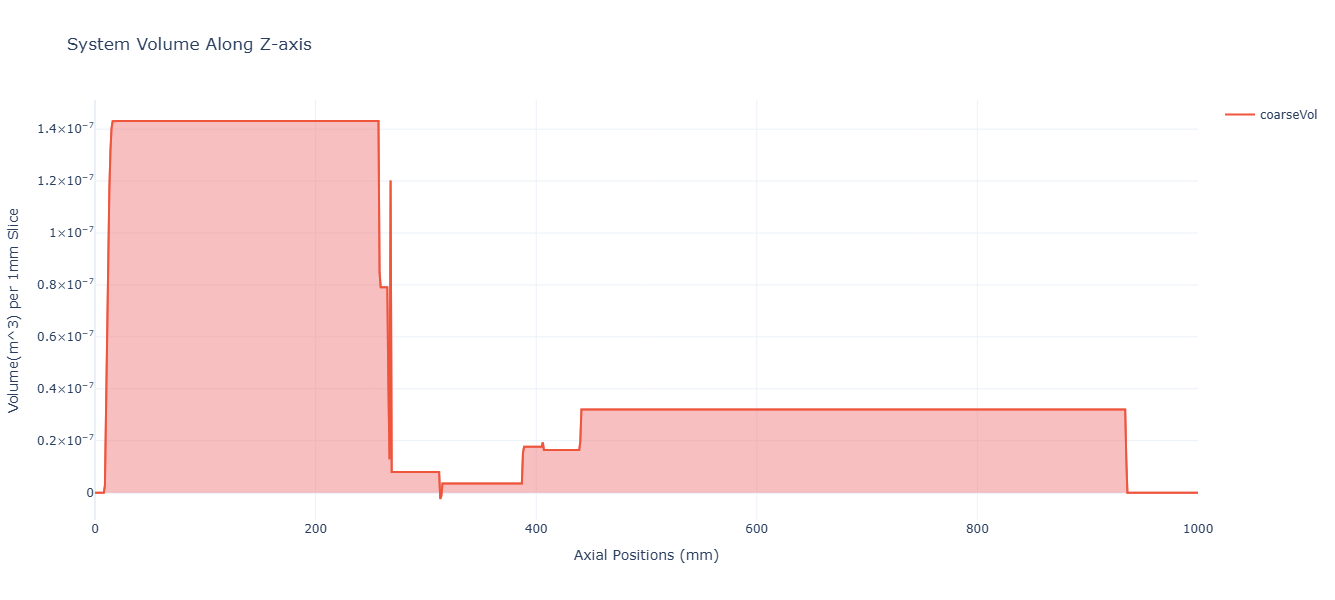

runtempsDF:
       CV1-TC38 CV1-TC48 CV1-TC36 CV1-TC47 CV1-TC34 CV1-TC34 CV1-TC34  \
12         21.5     21.7     21.3     21.6     21.4     21.4     21.4   
13         21.5     21.7     21.3     21.6     21.4     21.4     21.4   
14         21.5     21.7     21.4     21.6     21.4     21.4     21.4   
15         21.5     21.7     21.4     21.6     21.4     21.4     21.4   
16         21.5     21.7     21.4     21.6     21.4     21.4     21.4   
...         ...      ...      ...      ...      ...      ...      ...   
140808     20.5     20.6     20.3     20.5     20.3     20.3     20.3   
140809     20.5     20.6     20.3     20.5     20.3     20.3     20.3   
140810     20.5     20.6     20.3     20.5     20.3     20.3     20.3   
140811     20.5     20.6     20.3     20.5     20.3     20.3     20.3   
140812     20.5     20.6     20.3     20.5     20.3     20.3     20.3   

       CV1-TC34 CV1-TC46 CV1-TC32 CV1-TC30  
12         21.4     21.6     21.5     21.3  
13         21.4     2

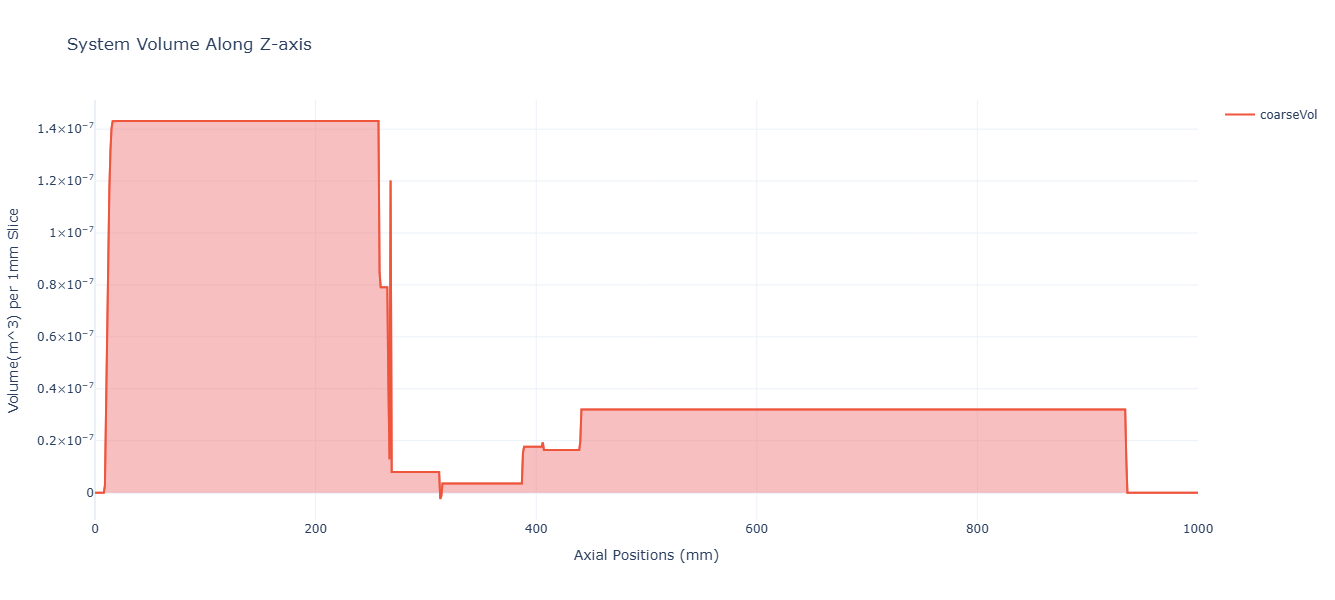

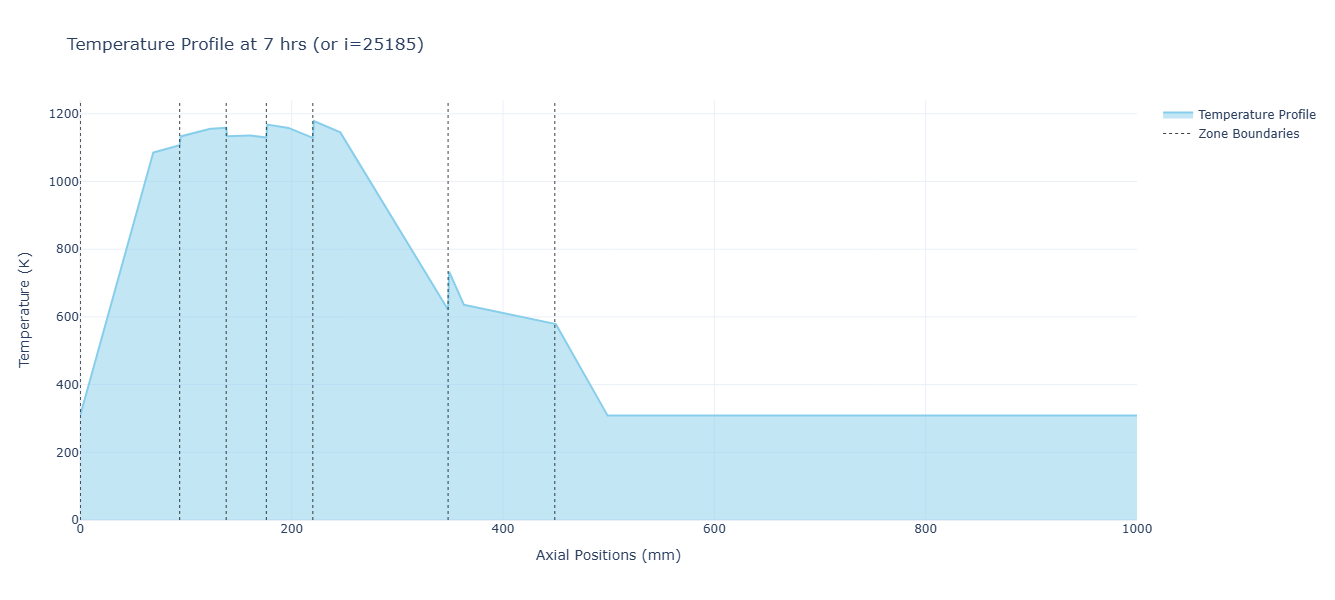

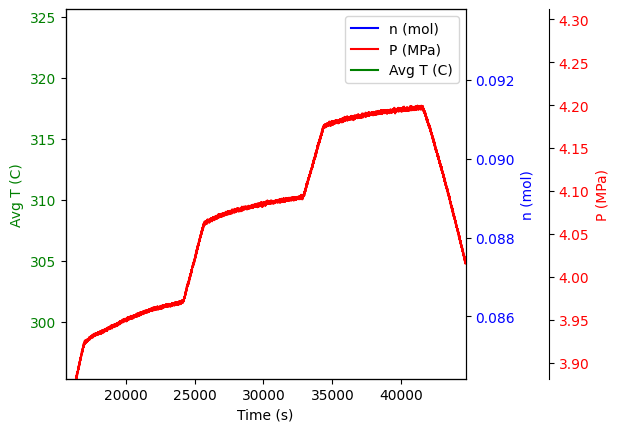

In [1]:
# Clears out any variables, just to be safe.
%reset -f

import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter import filedialog 
from tkinter.ttk import Progressbar
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import plotly.graph_objects as go
import numpy as np
import math
import os
import re
import sys
import json
import ast
from time import perf_counter
from time import perf_counter_ns
import seaborn as sns

# --- Global variables for file paths ---
data_filename = ""
temp_profile_file = "" 
layout_file = "" # NEW
mating_table_file = "" # NEW
fur_file = "" # NEW
hps_file = "" # NEW
runData = [] 
runBool = False 
imageViewer = None 
baselineEdited = False 
z_temp_cutoff_var = None 
z_offset_var = None 

# --- MODIFIED: browseFiles function ---
def browseFiles():
    global data_filename, temp_profile_file, layout_file, mating_table_file, fur_file, hps_file
    
    # 1. Ask for the Data CSV file
    data_filename = filedialog.askopenfilename(
        initialdir=os.path.expanduser('~\\Lehigh University Dropbox'), 
        title="1. Select Data CSV File", 
        filetypes=(("CSV files", "*.csv*"), ("all files", "*.*"))
    )
    if data_filename:
        fileLabel.configure(text=f"Data File: {os.path.basename(data_filename)}")
    else:
        fileLabel.configure(text="Data File: (Not Selected)")
    
    start_dir = os.path.dirname(data_filename) if data_filename else os.path.expanduser('~')
        
    # 2. Ask for Temperature Profile file
    temp_profile_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="2. Select Temperature Profile CSV File (e.g., ...TempCal.csv)",
        filetypes=(("CSV files", "*.csv*"), ("all files", "*.*"))
    )
    if temp_profile_file:
        tempLabel.configure(text=f"Temp Profile: {os.path.basename(temp_profile_file)}")
    else:
        tempLabel.configure(text="Temperature Profile: (Not Selected)")
        
    # --- NEW: Ask for all 4 geometry files ---
    
    # 3. Autoclave Layout
    layout_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="3. Select Autoclave Layout File (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if layout_file:
        layoutLabel.configure(text=f"Layout File: {os.path.basename(layout_file)}")
    else:
        layoutLabel.configure(text="Layout File: (Not Selected)")
        
    # 4. Mating Table
    mating_table_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="4. Select Surface Mating Table (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if mating_table_file:
        matingLabel.configure(text=f"Mating Table: {os.path.basename(mating_table_file)}")
    else:
        matingLabel.configure(text="Mating Table: (Not Selected)")
        
    # 5. MLD-FUR
    fur_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="5. Select MLD - FUR File (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if fur_file:
        furLabel.configure(text=f"MLD-FUR File: {os.path.basename(fur_file)}")
    else:
        furLabel.configure(text="MLD-FUR File: (Not Selected)")
        
    # 6. MLD-HPS
    hps_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="6. Select MLD - HPS File (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if hps_file:
        hpsLabel.configure(text=f"MLD-HPS File: {os.path.basename(hps_file)}")
    else:
        hpsLabel.configure(text="MLD-HPS File: (Not Selected)")
    
    window.update_idletasks()

# --- Original getData function (from Cell 4) ---
def getData(runDF, EXP_ID):
    print("running getData")
    config_path = os.path.expanduser(r"~\Lehigh University Dropbox\ENG-MATSGroup\MATS\cRIO\RunConfig\EXPs\\") + EXP_ID + '.csv'
    print(config_path)
    
    try:
        TC_df = pd.read_csv(config_path, usecols=['Device Type', 'NI LV Channel','Shorthand Tag'])
    except FileNotFoundError:
        print(f"Error: Cannot find TC config file: {config_path}")
        graphLabel.configure(text=f"Error: Cannot find TC config file for {EXP_ID}.csv")
        return None, None, None 
        
    TC_positions = pd.DataFrame([[int(num) for num in re.findall(r"\d+", name)][1] for name, type in zip(TC_df['Shorthand Tag'], TC_df['Device Type']) if type == 'TC'])
    print("TC Positions")
    print(TC_positions)
    TC_df['X Position'] = TC_positions
    TC_df = TC_df.dropna()
    TC_df = TC_df.sort_values(by='X Position')
    TC_positions=TC_df['X Position']
    print("TC_positions:")
    print(TC_positions)
    print("TC_df:")
    print(TC_df)
    RelevantColumns = TC_df['NI LV Channel'].to_list() 
    runDF = runDF[RelevantColumns+["CV1-TC-Ambient"]][8:].dropna()
    
    return runDF, TC_df, TC_positions

# --- MODIFIED: getTempProfile function (from Cell 5) ---
def getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list): 
    temps = [float(temp) for temp in temps]
    profileSegments = []
    for i in range(len(z_list_str)):
        temp_df = temp_df_list[i]
        
        search_column = temp_df[z_list_str[i]]
        idx = search_column.searchsorted(temps[i])
        safe_idx = min(idx, len(temp_df) - 1)
        tempList = temp_df.iloc[safe_idx]
            
        profileSegments.append(tempList)
    
    tempProfile = pd.concat(profileSegments)
    tempProfile = tempProfile[~tempProfile.index.duplicated(keep='first')].tolist()
    return tempProfile

# --- Original getPartVolProfile function (from Cell 6) ---
def getPartVolProfile(data):
    APdata = data["Axial Position (mm)"]
    CSdata=data["Cross-Sectional Area (mm^2)"]
    TMdata=data["Transition Model"]
    areaProfile = []
    for i in range(len(APdata)-1):
        x = np.arange(APdata[i], APdata[i+1], 0.1)
        if TMdata[i] != 'Constant':
            sectionAreaProfile = eval(TMdata[i])
        else:
            sectionAreaProfile = np.full((1,len(x)), CSdata[i])[0] 
        areaProfile.append(sectionAreaProfile)
    areaProfile.append(np.array([CSdata[-1]]))
    areaProfile = np.concatenate(areaProfile)
    volumeProfile = [0.1*slice for slice in areaProfile]
    return volumeProfile

# --- MODIFIED: getSystemVolumeProfile function (from Cell 7) ---
# Now takes the partList DF and the individual file paths
def getSystemVolumeProfile(partList, mating_table_path, fur_path, hps_path):
    isReversed = False
    previousIsReversed = False
    cumulativeOffset = 0
    
    # --- Paths are now passed as arguments ---
    try:
        planeTable = pd.read_excel(mating_table_path)
        furnitureDict = pd.read_excel(fur_path, sheet_name=['CRU', 'LID', 'PLU', 'VRE', 'TUB'])
        HPSDict = pd.read_excel(hps_path, sheet_name=['AC', 'GKT', 'NZ'])
        
    except FileNotFoundError as e:
        print(f"Error: Could not find required geometry file: {e.filename}")
        graphLabel.configure(text=f"Error: File not found: {os.path.basename(e.filename)}")
        window.update_idletasks()
        return None 
    except Exception as e:
        print(f"Error reading geometry files: {e}")
        graphLabel.configure(text=f"Error reading file: {e}")
        window.update_idletasks()
        return None

    CRU, LID, PLU, VRE, TUB = [sheet[["UID", "Profile"]].dropna() for sheet, key in zip(furnitureDict.values(), furnitureDict.keys())]
    AC, GKT, NZ = [sheet[["UID", "Profile"]].dropna() for sheet, key in zip(HPSDict.values(), HPSDict.keys())]
    partsDF = pd.concat([CRU,LID,PLU,VRE,AC,GKT,NZ,TUB], ignore_index=True)
    
    def safe_parse_profile(profile):
        if isinstance(profile, str):
            profile = profile.strip()
            if profile.endswith("'") or profile.endswith('"'):
                profile = profile[:-1]
            if profile.startswith("'") or profile.startswith('"'):
                profile = profile[1:]
            return ast.literal_eval(profile)
        return profile
    
    partList = partList.dropna()
    relevantParts = pd.DataFrame(columns=['UID', 'Profile'])
    
    for index, row in partList.iterrows():
        partProfile = partsDF.loc[partsDF['UID'] == row['UID']]
        if len(partProfile)!=0:
            relevantParts=pd.concat([relevantParts, partProfile], ignore_index=True)
    
    maxAxialPosition=10000
    colNames=["Axial Position"]
    dummyarray = np.empty((maxAxialPosition,))
    dummyarray[:] = np.nan
    volumeDF=pd.DataFrame(dummyarray, columns=colNames) 
    
    mate_positions = []
    uid0 = str(relevantParts["UID"].iloc[0])
    mate_positions.append({
        "Part":f"Part_0_{uid0}",
        "Previous Mate Position": None,
        "Next Mate Position": None
    })
    
    partVolumes = {}
    placement_summaries = []
    
    for i in range(len(relevantParts) - 1):
        previousPart = safe_parse_profile(relevantParts["Profile"].iloc[i])
        nextPart = safe_parse_profile(relevantParts["Profile"].iloc[i + 1])
        
        previousPartPlanes = previousPart['Contact Plane']
        nextPartPlanes = nextPart['Contact Plane']
        nextPartPlanesReversed = [''.join([char if char != '^' and char != 'v' else '^' if char == 'v' else 'v'
                                       for char in plane]) for plane in list(reversed(nextPartPlanes))]
                                  
        previousPartAxialPositions = previousPart.get('Axial Position (mm)', None)
        nextPartAxialPositions = nextPart.get('Axial Position (mm)', None)
        previousPartVolumeProfile = getPartVolProfile(previousPart)
                                  
        if i==0:
            colName0 = f"Part_0_{uid0}"
            volumeDF.insert(
                1,
                colName0,
                pd.Series(previousPartVolumeProfile, index=range(len(previousPartVolumeProfile))))
            cumulativeOffset = (len(previousPartVolumeProfile)-1) / 10.0
            
        if isReversed: 
            previousPartPlanes = [''.join([char if char!='^' and char!='v' else '^' if char == 'v' else 'v' for char in plane]) for plane in list(reversed(previousPartPlanes))] 
            previousPartAxialPositions.reverse()
            previousPartVolumeProfile.reverse()
            previousIsReversed = True
            
        mateList = [planeTable.loc[planeTable['Plane'] == plane]['Valid Mates'].tolist()[-1].split(', ') if plane else [] for plane in previousPartPlanes] 
        
        normalMates = []
        reversedMates = []
        
        for j in reversed(range(len(mateList))):
            is_rest = lambda s: "REST" in str(s).upper()
            nn = [c for c in normalMates if not is_rest(c[0])]
            rr = [c for c in reversedMates if not is_rest(c[0])]
            if nn or rr:
                normalMates, reversedMates = nn, rr 
            
            for k in range(len(nextPartPlanes)):
                if nextPartPlanes[k] in mateList[j]:
                    normalMates.append([previousPartPlanes[j], j, nextPartPlanes[k], k])
            for k in range(len(nextPartPlanesReversed)):
                if nextPartPlanesReversed[k] in mateList[j]:
                    reversedMates.append([previousPartPlanes[j], j, nextPartPlanesReversed[k], k])
        
        if len(normalMates) > 0 and len(reversedMates) == 0:
            print('Using normal orientation')
            validMateList = normalMates[0]
            isReversed = False
        elif len(reversedMates) > 0 and len(normalMates) == 0:
            validMateList = reversedMates[0]
            isReversed=True
            print(f"Reversed orientation used for {relevantParts['UID'].iloc[i+1]}")
        elif len(normalMates)>0 and len(reversedMates)>0:
            jn, jr = normalMates[0][1], reversedMates[0][1]
            if any(x in relevantParts["UID"].iloc[i+1] for x in ["AC", "GKT","GPA"]):
                validMateList = normalMates[0]
                print('UID contains AC, GKT or GPA - using normal orientation')
            elif jr == jn:
                validMateList = normalMates[0]
                isReversed = False
            elif jr != jn:
                if jr > jn:
                    validMateList = reversedMates[0]
                    isReversed = True
                    print(f"Reversed orientation used for {relevantParts['UID'].iloc[i+1]} to honor top-most plane")
                else:
                    validMateList = normalMates[0]; isReversed = False
                    print("Preferring NORMAL to honor topmost previous-plane")
            elif any([any(x in str(plane) for x in ['GASK', 'ORING']) for plane in normalMates]):
                validMateList = normalMates[0]
                isReversed = False
                print('Prioritizing GASK or ORING plane from nextPartPlanes - Normal Mate')
            elif any([any(x in str(plane) for x in ['GASK', 'ORING']) for plane in reversedMates]):
                validMateList = reversedMates[0]
                isReversed=True
                print(f"Reversed orientation used for {relevantParts['UID'].iloc[i+1]}")
            else:
                print('Multiple mates. Defaulting to first match')
                validMateList = normalMates[0]
                isReversed = False
        else:
            sys.exit(f"No valid mates for {relevantParts['UID'].iloc[i+1]} to {relevantParts['UID'].iloc[i]}. Halting program.")
               
        nextPartVolumeProfile = getPartVolProfile(nextPart)
        partVolume_mm3 = np.sum(nextPartVolumeProfile)
        partVolumes[relevantParts['UID'].iloc[i+1]] = partVolume_mm3
        
        if isReversed:
            nextPartAxialPositions.reverse()
            x_max = max(nextPartAxialPositions)
            nextPartAxialPositions = [x_max-x for x in nextPartAxialPositions]
            nextPartVolumeProfile.reverse()
            
        j = validMateList[1] 
        k = validMateList[3] 
        
        prev_part_end = max(previousPartAxialPositions)
        next_start = min(nextPartAxialPositions)
        
        if previousIsReversed:
            d_prev = previousPartAxialPositions[j]
        else:
            d_prev = prev_part_end - previousPartAxialPositions[j]
        
        d_next = nextPartAxialPositions[k]
        
        if previousPartAxialPositions[j] == prev_part_end and nextPartAxialPositions[k] == next_start:
            part_Offset = 0.0  
        else:
            part_Offset = d_prev + d_next
        
        part_length = (len(nextPartVolumeProfile)-1) / 10.0
        start_pos = cumulativeOffset - part_Offset
        end_pos = start_pos + part_length
        next_mate = round(start_pos + nextPartAxialPositions[k],3)
        
        next_part_uid = relevantParts['UID'].iloc[i+1]
        colName = f"Part_{i+1}_{next_part_uid}"
        slice_idx = [int(10 * start_pos) + num for num in range(len(nextPartVolumeProfile))]
        volumeDF.insert(i+2, colName, pd.Series(nextPartVolumeProfile, index=slice_idx))
        
        uid_prev = relevantParts['UID'].iloc[i]
        summary = [(f"{uid_prev} mated to {next_part_uid} at {next_mate} mm"),
                   (f"{validMateList[0]} → {validMateList[2]}")]
        placement_summaries.append(summary)
        
        if i == 0:
            mate_positions[0]["Previous Mate Position"] = 0.00
        
        mate_positions.append({
            "Part": f"Part_{i+1}_{next_part_uid}",
            "Previous Mate Position": start_pos,
            "Next Mate Position": next_mate
        })
        mate_positionsDF = pd.DataFrame(mate_positions).reset_index(drop=True)
        
        cumulativeOffset = start_pos + part_length
        
    mates = [mate_positions[i]["Next Mate Position"] for i in range(len(relevantParts)-1)]
        
    indexList = [round(0.1*i, 1) for i in range(int(maxAxialPosition))]
    volumeDF["Axial Position"] = indexList
    volumeDF["Total Volume"] = volumeDF.iloc[:, 1:].sum(axis=1)
       
    print("\nPLACEMENT SUMMARY:")
    print("-" * 60)
    for pos, mates_summary in placement_summaries: 
        print(pos)
        print(mates_summary)
        print("-" * 60)
            
    print("\nMate Positions")    
    print(mate_positionsDF)
        
    print("\nVolume per part (mL):")
    for col in volumeDF.columns:
        if col.startswith("Part_"):
            v_mm3 = volumeDF[col].sum()
            print(f"{col}: {v_mm3/1000:.3f} mL")
            
    print('\npartList:', partList)
    volumeDF.to_csv('volumeDF_AC-TG.csv', index=True)
    
    for col in volumeDF.columns:
        if col.startswith("Part"):
            not_nan = volumeDF[col].notna()
            y_data = volumeDF.loc[not_nan, col]
            x_data = volumeDF.loc[not_nan, "Axial Position"]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral')))
            fig.update_layout(
                title=f"Volume Profile of {col}",
                xaxis_title='Axial Positions (mm)',
                yaxis_title='Volume(mm^3) per 0.1mm Slice',   
                hovermode='x unified',
                template='plotly_white',
                width = 1300,
                height = 600,
                xaxis_range=[x_data.min(), x_data.max()]
            )
            fig.update_yaxes(exponentformat='power')
            fig.show()
    
    x_values = volumeDF["Axial Position"]
    y_data = volumeDF["Total Volume"]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral'),showlegend=False))
    fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', name='VolumeDF'))
    for pos_dict in mate_positions: 
        pos = pos_dict.get("Next Mate Position")
        if pos is not None:
            fig.add_vline(x=pos, line_dash="dash", line_color="black", line_width=1)    
    
    fig.update_layout(
        title='System Volume Along Z-axis',
        xaxis_title='Axial Positions (mm)',
        yaxis_title='Volume(mm^3) per 0.1mm Slice',   
        hovermode='x unified',
        template='plotly_white',
        width = 1300,
        height = 600
    )
    
    fig.update_yaxes(exponentformat='power')
    fig.show()

    return volumeDF

# --- MODIFIED: processData function (from Cell 9) ---
def processData():
    global runData, baselineEdited, graphLabel, fileProgress, graphProgress
    global data_filename, temp_profile_file, layout_file, mating_table_file, fur_file, hps_file
    global z_temp_cutoff_var, z_offset_var
    
    # --- Updated File Checks ---
    if not data_filename:
        graphLabel.configure(text="Error: Please select a Data File.")
        window.update_idletasks()
        return
    if not temp_profile_file:
        graphLabel.configure(text="Error: Please select a Temperature Profile File.")
        window.update_idletasks()
        return
    if not layout_file:
        graphLabel.configure(text="Error: Please select an Autoclave Layout file.")
        return
    if not mating_table_file:
        graphLabel.configure(text="Error: Please select a Mating Table file.")
        return
    if not fur_file:
        graphLabel.configure(text="Error: Please select an MLD-FUR file.")
        return
    if not hps_file:
        graphLabel.configure(text="Error: Please select an MLD-HPS file.")
        return
    # --- End Checks ---
        
    z_temp_cutoff_mm = None 
    try:
        z_cutoff_input = z_temp_cutoff_var.get()
        if z_cutoff_input: 
            z_temp_cutoff_mm = int(float(z_cutoff_input)) 
            print(f"Using user-defined temperature cutoff at: {z_temp_cutoff_mm} mm")
    except ValueError:
        graphLabel.configure(text=f"Error: Invalid Z-Temp Cutoff '{z_cutoff_input}'. Must be a number.")
        return
        
    z_offset_mm = 0 
    try:
        z_offset_input = z_offset_var.get()
        if z_offset_input: 
            z_offset_mm = int(float(z_offset_input))
            print(f"Applying Z-Offset of: {z_offset_mm} mm")
    except ValueError:
        graphLabel.configure(text=f"Error: Invalid Z-Offset '{z_offset_input}'. Must be a number.")
        return
    
    fileProgress.grid(row=19, column=3) # Use new row 19
    fileProgress['value']=0
    window.update_idletasks()
    
    try:
        df = pd.read_csv(data_filename, low_memory=False)
    except Exception as e:
        graphLabel.configure(text=f"Error reading Data CSV: {e}")
        return
    
    fileProgress['value'] = 20
    window.update_idletasks() 
    
    runID = df.iloc[12,10]
    EXP_ID = df.iloc [6, 20]
    print("Run ID", runID)
    print("EXP ID", EXP_ID)

    runDF, TC_df, TC_positions = getData(df, EXP_ID)
    if runDF is None: 
        return 

    try:
        P_MPa=df['CVFP-PT-CV-A2'][8:].dropna() 
    except:
        try:
            P_MPa=df['CVFP-PT-CV-A'][8:].dropna()
        except:
             graphLabel.configure(text="Error: Could not find Pressure column (CVFP-PT-CV-A2 or A)")
             return
    P_MPa = P_MPa.astype(float)
    print("Pressure")
    print(len(P_MPa))
    print(P_MPa)
    P_Pa=[float(p)*1000000 for p in P_MPa]
    fileProgress['value'] = 80
    window.update_idletasks() 
    
    Time_Minutes=df['Relative.2'][-len(P_MPa):].tolist()
    print("Minutes")
    print(len(Time_Minutes))
    
    Time_Seconds= pd.Series([float(min)*60 for min in Time_Minutes])
    Time_Hours=[float(min)/60 for min in Time_Minutes]   

    # --- MODIFIED: Load partList from layout_file ---
    try:
        partList=pd.read_excel(layout_file)
    except FileNotFoundError:
        graphLabel.configure(text=f"Error: '{os.path.basename(layout_file)}' not found.")
        return
        
    # --- MODIFIED: Pass the individual file paths ---
    volumeDF = getSystemVolumeProfile(partList, mating_table_file, fur_file, hps_file)
    if volumeDF is None:
        return
    # --- End Modification ---
    
    volumeProfile = volumeDF['Total Volume'].to_list()
    fineVol = volumeProfile[:]
    volumeProfile += [0] * (10 - len(volumeProfile) % 10)
    coarseVol = []

    for i in range(int(len(volumeProfile) / 10)):
        summed_volume_mm3 = sum(volumeProfile[10 * i : 10 * (i + 1)])
        coarseVol.append(summed_volume_mm3)

    coarseVol = [vol / 1e9 for vol in coarseVol]
    coarseVol_mL = [v*1e6 for v in coarseVol]
    
    print("\n")
    total_volume_mm3 = volumeDF['Total Volume'].sum()
    print("Total System Volume from VolumeDF (mL):", sum(fineVol) / 1000)
    print("Total System Volume from CoarseVol (mL):", sum(coarseVol_mL))
    
    x_values = list(range(len(coarseVol)))
    y_data = coarseVol
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral'),showlegend=False))
    fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', name='coarseVol'))    
    
    fig.update_layout(
        title='System Volume Along Z-axis',
        xaxis_title='Axial Positions (mm)',
        yaxis_title='Volume(m^3) per 1mm Slice',   
        hovermode='x unified',
        template='plotly_white',
        width = 1300,
        height = 600
    )
    fig.update_yaxes(exponentformat='power')
    fig.show()
        
    # --- MODIFIED: Load lookupTable from temp_profile_file ---
    try:
        lookupTable = pd.read_csv(temp_profile_file, index_col=0)
    except FileNotFoundError:
        graphLabel.configure(text=f"Error: Could not find Temp Profile: {os.path.basename(temp_profile_file)}")
        return
    except Exception as e:
        graphLabel.configure(text=f"Error reading Temp Profile: {e}")
        return
    # --- End Modification ---
        
    lookupTable.columns = [str(int(float(c))) for c in lookupTable.columns]
    
    TC_dist_list = TC_df['X Position']
    runTempsDF = runDF[TC_df['NI LV Channel']]
    print("runtempsDF:")
    print(runTempsDF)
    print(f"runTempsDF length = {len(runTempsDF)}")
    print(f"P_Pa length = {len(P_Pa)}")
    R=8.3145 #Gas constant, J/molK
    avgTempList = []
    
    z_min_cal = 0
    z_max_cal = 449
    last_TC = max(TC_positions)

    z_list_cal = [z_min_cal] + TC_positions.tolist() + [z_max_cal]
    z_list_cal = sorted(set(z_list_cal))
    z_list_cal = [float(f"{int(z):.1f}") for z in z_list_cal]

    zoneBounds = [z_list_cal[0]] + [round(0.5 * (z_list_cal[i] + z_list_cal[i+1])) for i in range(1, len(z_list_cal)-1)] + [z_list_cal[-1]]
    zoneBounds = [float(f"{int(b):.1f}") for b in zoneBounds]
    zoneBoundsStr = [str(int(round(b))) for b in zoneBounds]
    z_list = z_list_cal[1:]
    z_list_str = [str(int(round(x))) for x in z_list_cal[1:]] 
    print("z_list_str:")
    print(z_list_str[0:20])

    temp_df_list = []

    for i in range(len(z_list_str)):
        temp_df = lookupTable.loc[:, zoneBoundsStr[i]:zoneBoundsStr[i+1]]
        temp_df = temp_df.sort_values(by=[z_list_str[i]])
        temp_df_list.append(temp_df)
    
    graphProgress.grid(row=19, column=2, sticky=W) # Use new row 19
    graphProgress['value']=0
    window.update_idletasks()
        
    n=[]    
    t_prof_ex = [] 
    
    for i in range(len(runTempsDF)):
        temps = runTempsDF.iloc[i].to_list()
        tempProfile_raw = getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list)
        avgTempList.append(sum(tempProfile_raw)/len(tempProfile_raw))
        tempProfile = [temp + 273.15 for temp in tempProfile_raw] # Convert to K
        
        ambient_temp = float(runDF["CV1-TC-Ambient"].iloc[i])
        ambient_temp = ambient_temp + 273.15
        
        if z_temp_cutoff_mm is not None:
            if z_temp_cutoff_mm < len(tempProfile):
                tempProfile = tempProfile[:z_temp_cutoff_mm]
            elif z_temp_cutoff_mm > len(tempProfile):
                fill_needed = z_temp_cutoff_mm - len(tempProfile)
                tempProfile.extend([tempProfile[-1]] * fill_needed)

        last_cal_temp = float(tempProfile[-1])
        temp_gradient = np.linspace(last_cal_temp, ambient_temp, 50) 
        tempProfile.extend(temp_gradient)
        
        if len(coarseVol)>len(tempProfile):
            tempProfile += [ambient_temp]*((len(coarseVol)-len(tempProfile)))
        
        V_aligned = coarseVol
        T_aligned = tempProfile
        
        if z_offset_mm > 0:
            T_aligned = tempProfile[z_offset_mm:]
        elif z_offset_mm < 0:
            V_aligned = coarseVol[abs(z_offset_mm):]
        
        final_len = min(len(V_aligned), len(T_aligned))
        V = np.array(V_aligned[:final_len])
        T = np.array(T_aligned[:final_len])
        
        P = P_Pa[i]  
        nList = (P * V) / (R * T)
        
        if i==25185:
            t_prof_ex = T

        n.append(sum(nList))
        if i%1000 == 0:
            print(Time_Hours[i])
            graphProgress['value'] = int(100*i/len(runTempsDF))
            window.update_idletasks()
            
    x_values = list(range(len(coarseVol)))
    y_data = coarseVol
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral'),showlegend=False))
    fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', name='coarseVol'))    
    fig.update_layout(
        title='System Volume Along Z-axis',
        xaxis_title='Axial Positions (mm)',
        yaxis_title='Volume(m^3) per 1mm Slice',   
        hovermode='x unified',
        template='plotly_white',
        width = 1300,
        height = 600
    )
    fig.update_yaxes(exponentformat='power')
    fig.show()
    
    if len(t_prof_ex) > 0: 
        x = list(range(len(t_prof_ex)))
        y = t_prof_ex
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x,y=y, mode='lines',fill='tozeroy',name="Temperature Profile", line=dict(color='#87CEEB')))
        for bound in zoneBounds:
            fig.add_vline(x=bound, line_dash="dot", line_color="black", line_width=0.75)
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='lines',
            line=dict(color="black", dash="dot", width=0.75),
            name='Zone Boundaries'
        ))
        fig.update_layout(
            title='Temperature Profile at 7 hrs (or i=25185)',
            xaxis_title='Axial Positions (mm)',
            yaxis_title='Temperature (K)',
            hovermode='x unified',
            template='plotly_white',
            width = 1300,
            height = 600
        )
        fig.update_yaxes(exponentformat='power')
        fig.show()
    else:
        print("Note: Temperature profile for i=25185 not recorded.")
                    
    rawData, baseline, baselineRange, baselineUnit, movingAvg, movingAvgRange, movingAvgUnit, tempRange, pressureRange, timeRange, nRange, dn_dtRange = (None, None, None, None, None, None, None, None, None, None, None, None)
    
    runData = [Time_Hours, Time_Minutes, Time_Seconds, n, P_MPa, avgTempList, runDF, TC_df, lookupTable, rawData, baseline, baselineRange, baselineUnit, baselineEdited, movingAvg, movingAvgRange, movingAvgUnit, df, data_filename, tempRange, pressureRange, timeRange, nRange, dn_dtRange]
    
    moleGraph(runData)
    fileProgress['value'] = 100
    graphProgress['value'] = 100
    fileProgress.grid_forget() 
    graphLabel.configure(text="Graph Generated Successfully")
    window.update_idletasks() 

# --- MODIFIED: moleGraph function (from Cell 10) ---
def moleGraph(runData):
    global runBool
    global imageViewer
    global baselineEdited
    
    [Time_Hours, Time_Minutes, Time_Seconds, n, P_MPa, avgTempList, runDF, TC_df, lookupTable, 
     rawData, baseline, baselineRange, baselineUnit, baselineEdited, movingAvg, movingAvgRange, 
     movingAvgUnit, df, fileName, tempRange, pressureRange, timeRange, nRange, dn_dtRange] = runData
    
    if runBool==True:
        if imageViewer: 
            imageViewer.destroy()
    
    runBool=True
    
    imageViewer = Toplevel(window)
    imageViewer.title(fileName) 
    imageViewer.geometry("1000x600")
    
    fig, ax1 = plt.subplots()
    fig.subplots_adjust(right=0.75) 
    
    # AXIS 1: Temperature (LEFT)
    p3, = ax1.plot(Time_Seconds, avgTempList, color='green', label='Avg T (C)')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Avg T (C)", color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    
    # AXIS 2: Moles (RIGHT)
    ax2 = ax1.twinx()
    p1, = ax2.plot(Time_Seconds, n, color='blue', label='n (mol)')
    ax2.set_ylabel("n (mol)", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # AXIS 3: Pressure (RIGHT, offset)
    ax3 = ax1.twinx()
    p2, = ax3.plot(Time_Seconds, P_MPa, color='red', label='P (MPa)')
    ax3.set_ylabel("P (MPa)", color='red')
    ax3.tick_params(axis='y', labelcolor='red')
    ax3.spines['right'].set_position(('outward', 60))
    
    ax1.legend(handles=[p1, p2, p3], loc=0)
    
    imageFrame = Frame(imageViewer)
    imageFrame.grid(row=2, column=1)
    
    canvas = FigureCanvasTkAgg(fig, master=imageFrame)
    canvas.draw()
    canvas.get_tk_widget().grid(row=1, column=1)
    
    toolbarFrame = Frame(imageViewer)
    toolbarFrame.grid(row=1, column=1)
    NavigationToolbar2Tk(canvas, toolbarFrame)
    
    baselineEdited = False 

# --- MODIFIED: MAIN GUI (from Cell 11) ---
window=Tk()
window.title("MoleGrapher 1.0.0")
window.geometry("500x400") # Increased height for new widgets

graphLabel = Label(window, text = "Press 'Generate Graph' to begin.", width = 100, anchor=W)
graphLabel.grid(row=1, column=1, columnspan=5, sticky=W)

fileBrowseButton = Button(window, text="Browse...", command=lambda: browseFiles(), anchor=W)
fileBrowseButton.grid(row=11, column=1, sticky=W)

fileLabel = Label(window, text="Select a Data CSV File", width=100, anchor=W)
fileLabel.grid(row=11, column=2, columnspan=5, sticky=W)

tempLabel = Label(window, text="Select Temperature Profile", width=100, anchor=W)
tempLabel.grid(row=12, column=2, columnspan=5, sticky=W)

# --- NEW: Geometry File Labels ---
layoutLabel = Label(window, text="Layout File: (Not Selected)", width=100, anchor=W)
layoutLabel.grid(row=13, column=2, columnspan=5, sticky=W)

matingLabel = Label(window, text="Mating Table: (Not Selected)", width=100, anchor=W)
matingLabel.grid(row=14, column=2, columnspan=5, sticky=W)

furLabel = Label(window, text="MLD-FUR File: (Not Selected)", width=100, anchor=W)
furLabel.grid(row=15, column=2, columnspan=5, sticky=W)

hpsLabel = Label(window, text="MLD-HPS File: (Not Selected)", width=100, anchor=W)
hpsLabel.grid(row=16, column=2, columnspan=5, sticky=W)
# --- END NEW ---

# --- RENAMED: Z-Temp Cutoff Entry ---
zCutoffLabel = Label(window, text="Z-Temp Cutoff (mm) [optional]:", width=25, anchor=W)
zCutoffLabel.grid(row=17, column=1, sticky=W) # New row 17

z_temp_cutoff_var = tk.StringVar(value='') 
zCutoffEntry = Entry(window, textvariable=z_temp_cutoff_var, width=20)
zCutoffEntry.grid(row=17, column=2, sticky=W)

# --- Z-Offset Entry ---
zOffsetLabel = Label(window, text="Z-Offset (mm) [optional]:", width=25, anchor=W)
zOffsetLabel.grid(row=18, column=1, sticky=W) # New row 18

z_offset_var = tk.StringVar(value='') 
zOffsetEntry = Entry(window, textvariable=z_offset_var, width=20)
zOffsetEntry.grid(row=18, column=2, sticky=W)

fileProgress = Progressbar(window, orient = HORIZONTAL, length = 100, mode = 'determinate')
# fileProgress.grid() is called inside processData

# --- Adjust row numbers ---
graphButton=Button(window, text="Generate Graph", command=lambda: processData(), anchor=W)
graphButton.grid(row=19, column=1, sticky=W) # New row 19

graphProgress = Progressbar(window, orient = HORIZONTAL, length = 200, mode = 'determinate') 
# graphProgress.grid() is called inside processData

window.attributes('-topmost', False) 

window.mainloop()